# D4 transform

Geomatric transforms are the most widely used augmentations. Mainly becase they do not get data outside of the original data distribution and because they "They make intuitive sense". 


**[D4](https://albumentations.ai/docs/api_reference/full_reference/?h=d4#albumentations.augmentations.geometric.transforms.D4)** transform maps orignal image to one of 8 states. 

- `e` - identity. The original image
- `r90` - rotation by 90 degrees
- `r180` - rotation by 180 degrees, which is equal to `v * h = h * v`
- `r270` - rotation by 270 degrees
- `v` - vertical flip
- `hvt` - reflection across anti diagonal, which is equal to `t * v * h` or `t * rot180` 
- `h` - horizonal flip
- `t` - reflection actoss the diagonal

The same transform could be represented as 

```python
A.Compose([A.HorizonatalFlip(p=0.5), A.RandomRotate90(p=1)])
```
Hence this is just a convenient notation.

The transform is useful in situations where imagery data does not have preferred orientation:

For example:
- medical images
- top view drone and satellite imagery

Works for:
- image
- mask
- keypoints
- bounding boxes

In [ ]:
%matplotlib inline

In [ ]:
import json

In [ ]:
import hashlib

In [ ]:
import random
import numpy as np
import cv2
from matplotlib import pyplot as plt

import albumentations as A

In [ ]:
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)
KEYPOINT_COLOR = (0, 255, 0)

In [ ]:
def visualize_bbox(img, bbox, class_name, bbox_color=BOX_COLOR, thickness=1):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = (int(x) for x in bbox)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=bbox_color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), bbox_color, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35,
        color=TEXT_COLOR,
        lineType=cv2.LINE_AA,
    )
    return img

def vis_keypoints(image, keypoints, color=KEYPOINT_COLOR, diameter=3):
    image = image.copy()
    for (x, y) in keypoints:
        cv2.circle(image, (int(x), int(y)), diameter, color, -1)
    return image

In [ ]:
def visualize_one(image, bboxes, keypoints, category_ids, category_id_to_name, mask):
    # Create a copy of the image to draw on
    img = image.copy()

    # Apply each bounding box and corresponding category ID
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)

    # Apply keypoints if provided
    if keypoints:
        img = vis_keypoints(img, keypoints)

    # Setup plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Show the image with annotations
    ax[0].imshow(img)    
    ax[0].axis('off')

    # Show the mask
    ax[1].imshow(mask, cmap='gray')    
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
def visualize(images, bboxes_list, keypoints_list, category_ids_list, category_id_to_name, masks):
    if len(images) != 8:
        raise ValueError("This function is specifically designed to handle exactly 8 images.")

    num_rows = 4
    num_cols = 4
    
    fig, axs = plt.subplots(num_cols, num_rows, figsize=(20, 20)) 

    for idx, (image, bboxes, keypoints, category_ids, mask) in enumerate(zip(images, bboxes_list, keypoints_list, category_ids_list, masks)):
        img = image.copy()

        # Process each image: draw bounding boxes and keypoints
        for bbox, category_id in zip(bboxes, category_ids):
            class_name = category_id_to_name[category_id]
            img = visualize_bbox(img, bbox, class_name)

        if keypoints:
            img = vis_keypoints(img, keypoints)

        # Calculate subplot indices
        row_index = (idx * 2) // num_rows  # Each pair takes two columns in one row
        col_index_image = (idx * 2) % num_cols  # Image at even index
        col_index_mask = (idx * 2 + 1) % num_cols  # Mask at odd index right after image

        # Plot the processed image
        img_ax = axs[row_index, col_index_image]
        img_ax.imshow(img)        
        img_ax.axis('off')

        # Plot the corresponding mask
        mask_ax = axs[row_index, col_index_mask]
        mask_ax.imshow(mask, cmap='gray')        
        mask_ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
with open("../data/road_labels.json") as f:
    labels = json.load(f)

In [ ]:
bboxes = labels["bboxes"]
keypoints = labels["keypoints"]

In [ ]:
bgr_image = cv2.imread("../data/road.jpeg")
image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

mask = cv2.imread("../data/road.png", 0)

In [ ]:
# In this example we use only one class, hence category_ids is list equal to the number of bounding boxes with only one value
category_ids = [1] * len(labels["bboxes"])
category_id_to_name = {1: "car"}

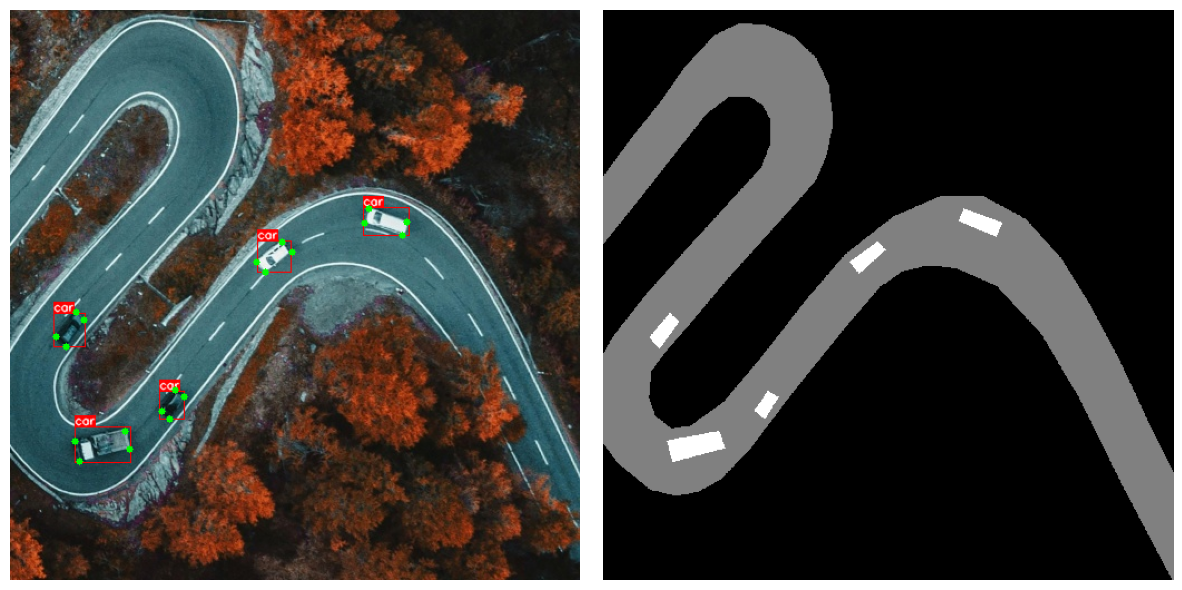

In [ ]:
visualize_one(image, bboxes, keypoints, category_ids, category_id_to_name, mask)

In [ ]:
import math
import random
from enum import Enum
from typing import Any, Dict, List, Literal, Optional, Sequence, Tuple, Union, cast
from warnings import warn

import cv2
import numpy as np
import skimage.transform
from pydantic import Field, ValidationInfo, field_validator, model_validator
from typing_extensions import Annotated, Self

from albumentations import random_utils
from albumentations.augmentations.functional import bbox_from_mask
from albumentations.augmentations.utils import BIG_INTEGER, check_range
from albumentations.core.bbox_utils import denormalize_bbox, normalize_bbox
from albumentations.core.pydantic import (
    BorderModeType,
    InterpolationType,
    NonNegativeFloatRangeType,
    ProbabilityType,
    SymmetricRangeType,
)
from albumentations.core.transforms_interface import BaseTransformInitSchema, DualTransform
from albumentations.core.types import (
    BoxInternalType,
    ColorType,
    D4Type,
    KeypointInternalType,
    ScaleFloatType,
    ScaleIntType,
    SizeType,
    Targets,
    d4_group_elements,
)
from albumentations.core.utils import to_tuple

import albumentations.augmentations.geometric.functional as F 

In [ ]:

def rot90(img: np.ndarray, factor: int) -> np.ndarray:
    img = np.rot90(img, factor)
    return np.ascontiguousarray(img)

In [ ]:
def transpose(img: np.ndarray) -> np.ndarray:
    """Transposes the first two dimensions of an array of any dimensionality.
    Retains the order of any additional dimensions.

    Args:
        img (np.ndarray): Input array.

    Returns:
        np.ndarray: Transposed array.
    """
    # Generate the new axes order
    new_axes = list(range(img.ndim))
    new_axes[0], new_axes[1] = 1, 0  # Swap the first two dimensions

    # Transpose the array using the new axes order
    return img.transpose(new_axes)

In [ ]:
def d4(img: np.ndarray, group_member: D4Type) -> np.ndarray:
    """Applies a `D_4` symmetry group transformation to an image array.

    This function manipulates an image using transformations such as rotations and flips,
    corresponding to the `D_4` dihedral group symmetry operations.
    Each transformation is identified by a unique group member code.

    Parameters:
    - img (np.ndarray): The input image array to transform.
    - group_member (D4Type): A string identifier indicating the specific transformation to apply. Valid codes include:
      - 'e': Identity (no transformation).
      - 'r90': Rotate 90 degrees counterclockwise.
      - 'r180': Rotate 180 degrees.
      - 'r270': Rotate 270 degrees counterclockwise.
      - 'v': Vertical flip.
      - 'hvt': Transpose over second diagonal
      - 'h': Horizontal flip.
      - 't': Transpose (reflect over the main diagonal).

    Returns:
    - np.ndarray: The transformed image array.

    Raises:
    - ValueError: If an invalid group member is specified.

    Examples:
    - Rotating an image by 90 degrees:
      `transformed_image = d4(original_image, 'r90')`
    - Applying a horizontal flip to an image:
      `transformed_image = d4(original_image, 'h')`
    """
    transformations = {
        "e": lambda x: x,  # Identity transformation
        "r90": lambda x: rot90(x, 1),  # Rotate 90 degrees
        "r180": lambda x: rot90(x, 2),  # Rotate 180 degrees
        "r270": lambda x: rot90(x, 3),  # Rotate 270 degrees
        # "v": vflip,  # Vertical flip
        "hvt": lambda x: transpose(rot90(x, 2)),  # Reflect over anti-diagonal
        # "h": hflip,  # Horizontal flip
        "t": transpose,  # Transpose (reflect over main diagonal)
    }

    # Execute the appropriate transformation
    if group_member in transformations:
        return np.ascontiguousarray(transformations[group_member](img))

    raise ValueError(f"Invalid group member: {group_member}")

In [ ]:
class D4(DualTransform):
    """Applies one of the eight possible D4 dihedral group transformations to a square-shaped input,
        maintaining the square shape. These transformations correspond to the symmetries of a square,
        including rotations and reflections.

    The D4 group transformations include:
    - 'e' (identity): No transformation is applied.
    - 'r90' (rotation by 90 degrees counterclockwise)
    - 'r180' (rotation by 180 degrees)
    - 'r270' (rotation by 270 degrees counterclockwise)
    - 'v' (reflection across the vertical midline)
    - 'hvt' (reflection across the anti-diagonal)
    - 'h' (reflection across the horizontal midline)
    - 't' (reflection across the main diagonal)

    Even if the probability (`p`) of applying the transform is set to 1, the identity transformation
    'e' may still occur, which means the input will remain unchanged in one out of eight cases.

    Args:
        p (float): Probability of applying the transform. Default is 1, meaning the
                   transform is applied every time it is called.

    Targets:
        image, mask, bboxes, keypoints

    Image types:
        uint8, float32

    Note:
        This transform is particularly useful when augmenting data that does not have a clear orientation:
        - Top view satellite or drone imagery
        - Medical images

    """

    _targets = (Targets.IMAGE, Targets.MASK, Targets.BBOXES, Targets.KEYPOINTS)

    class InitSchema(BaseTransformInitSchema):
        p: ProbabilityType = 1

    def __init__(
        self,
        always_apply: bool = False,
        p: float = 1,
    ):
        super().__init__(always_apply, p)

    def apply(self, img: np.ndarray, group_element: D4Type, **params: Any) -> np.ndarray:
        # return F.d4(img, group_element)
        return d4(img, group_element)

    def apply_to_bbox(self, bbox: BoxInternalType, group_element: D4Type, target_size: Tuple[int, int], **params: Any) -> BoxInternalType:
        # rows, cols = target_size
        return F.bbox_d4(bbox, group_element, **params)

    def apply_to_keypoint(
        self,
        keypoint: KeypointInternalType,
        group_element: D4Type,
        target_size: Tuple[int, int],
        **params: Any,
    ) -> KeypointInternalType:
        # rows, cols = target_size
        # print(params, {"rows": rows, "cols": cols})
        # return F.keypoint_d4(keypoint, group_element, rows=rows, cols=cols)
        return F.keypoint_d4(keypoint, group_element, **params)
    
    @property
    def targets_as_params(self) -> List[str]:
        return ["image"]

    def get_params_dependent_on_targets(self, params: Dict[str, Any]) -> Dict[str, Any]:
        height, width = params["image"].shape[:2]
        
        group_element = random_utils.choice(d4_group_elements)
        print("Group element", group_element)

        def get_target_size(group_element):
            if group_element in {"t", "hvt", "rot90", "rot180"}:
                return width, height
            return height, width
        
        return {
            "group_element": group_element,
            "target_size": get_target_size(group_element)
        }

    def get_transform_init_args_names(self) -> Tuple[()]:
        return ()


In [ ]:
transform = A.Compose([
    A.CenterCrop(width=512, height = 256, p=1),
    D4(p=1)
],
                     bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']),
                     keypoint_params=A.KeypointParams(format='xy')
                     )

In [ ]:
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids, keypoints=keypoints, mask=mask)
# transformed = transform(image=image)

Group element r90


In [ ]:
# visualize_one(image, bboxes, keypoints, category_ids, category_id_to_name, mask)

In [ ]:
# a = np.rot90(transformed["image"])

In [ ]:
# plt.imshow(a)

In [ ]:
transformed["image"].shape

(512, 256, 3)

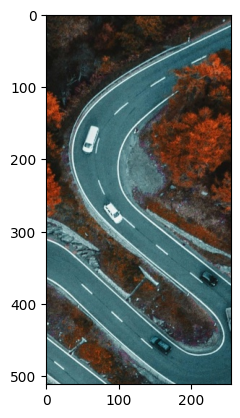

In [ ]:
plt.imshow(transformed["image"])

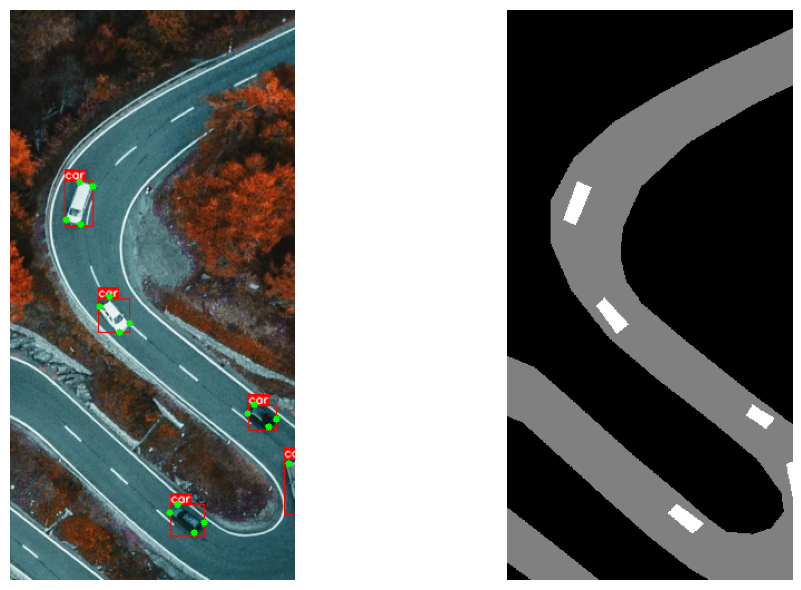

In [ ]:
visualize_one(transformed["image"], transformed["bboxes"], transformed["keypoints"], category_ids, category_id_to_name, transformed["mask"])

In [ ]:
def get_hash(image):
    image_bytes = image.tobytes()
    hash_md5 = hashlib.md5()
    hash_md5.update(image_bytes)    
    return hash_md5.hexdigest()
    

In [ ]:
transformations_dict = {}

for _ in range(80):
    transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids, keypoints=keypoints, mask=mask)
    image_hash = get_hash(transformed["image"])
    
    if image_hash in transformations_dict:
        transformations_dict[image_hash]['count'] += 1
    else:
        transformations_dict[image_hash] = {
            "count": 1,
            "transformed": transformed
        }

The transform generates all 8 possible variants with the same probability, including identity transform

In [ ]:
len(transformations_dict)

8

In [ ]:
for key in transformations_dict:
    print(key, transformations_dict[key]["count"])

5ec4b54817900aaa5b95ee79a998c285 11
4912e25db4fc72df3f39e58d543a3c4f 18
2e80aa7460797b9a2eab799c1ab1a4b4 7
fbb5fb0bdc1af613d0bf35e39ca02e99 13
f7213d6c7d49c26cbdc81f82d3116f59 6
950f8564839db6529cf7a51a9d1c7663 3
418c28701b5e6ba3f73940df30864de8 10
1238a83960a62ee498541f4e397e0068 12


In [ ]:
transformed_list = [value["transformed"] for value in transformations_dict.values()]

In [ ]:
images = [x["image"] for x in transformed_list]
masks = [x["mask"] for x in transformed_list]
bboxes_list = [x["bboxes"] for x in transformed_list]
keypoints_list = [x["keypoints"] for x in transformed_list]


category_ids_list = [[1] * len(x["bboxes"]) for x in transformed_list]
category_id_to_name = {1: "car"}

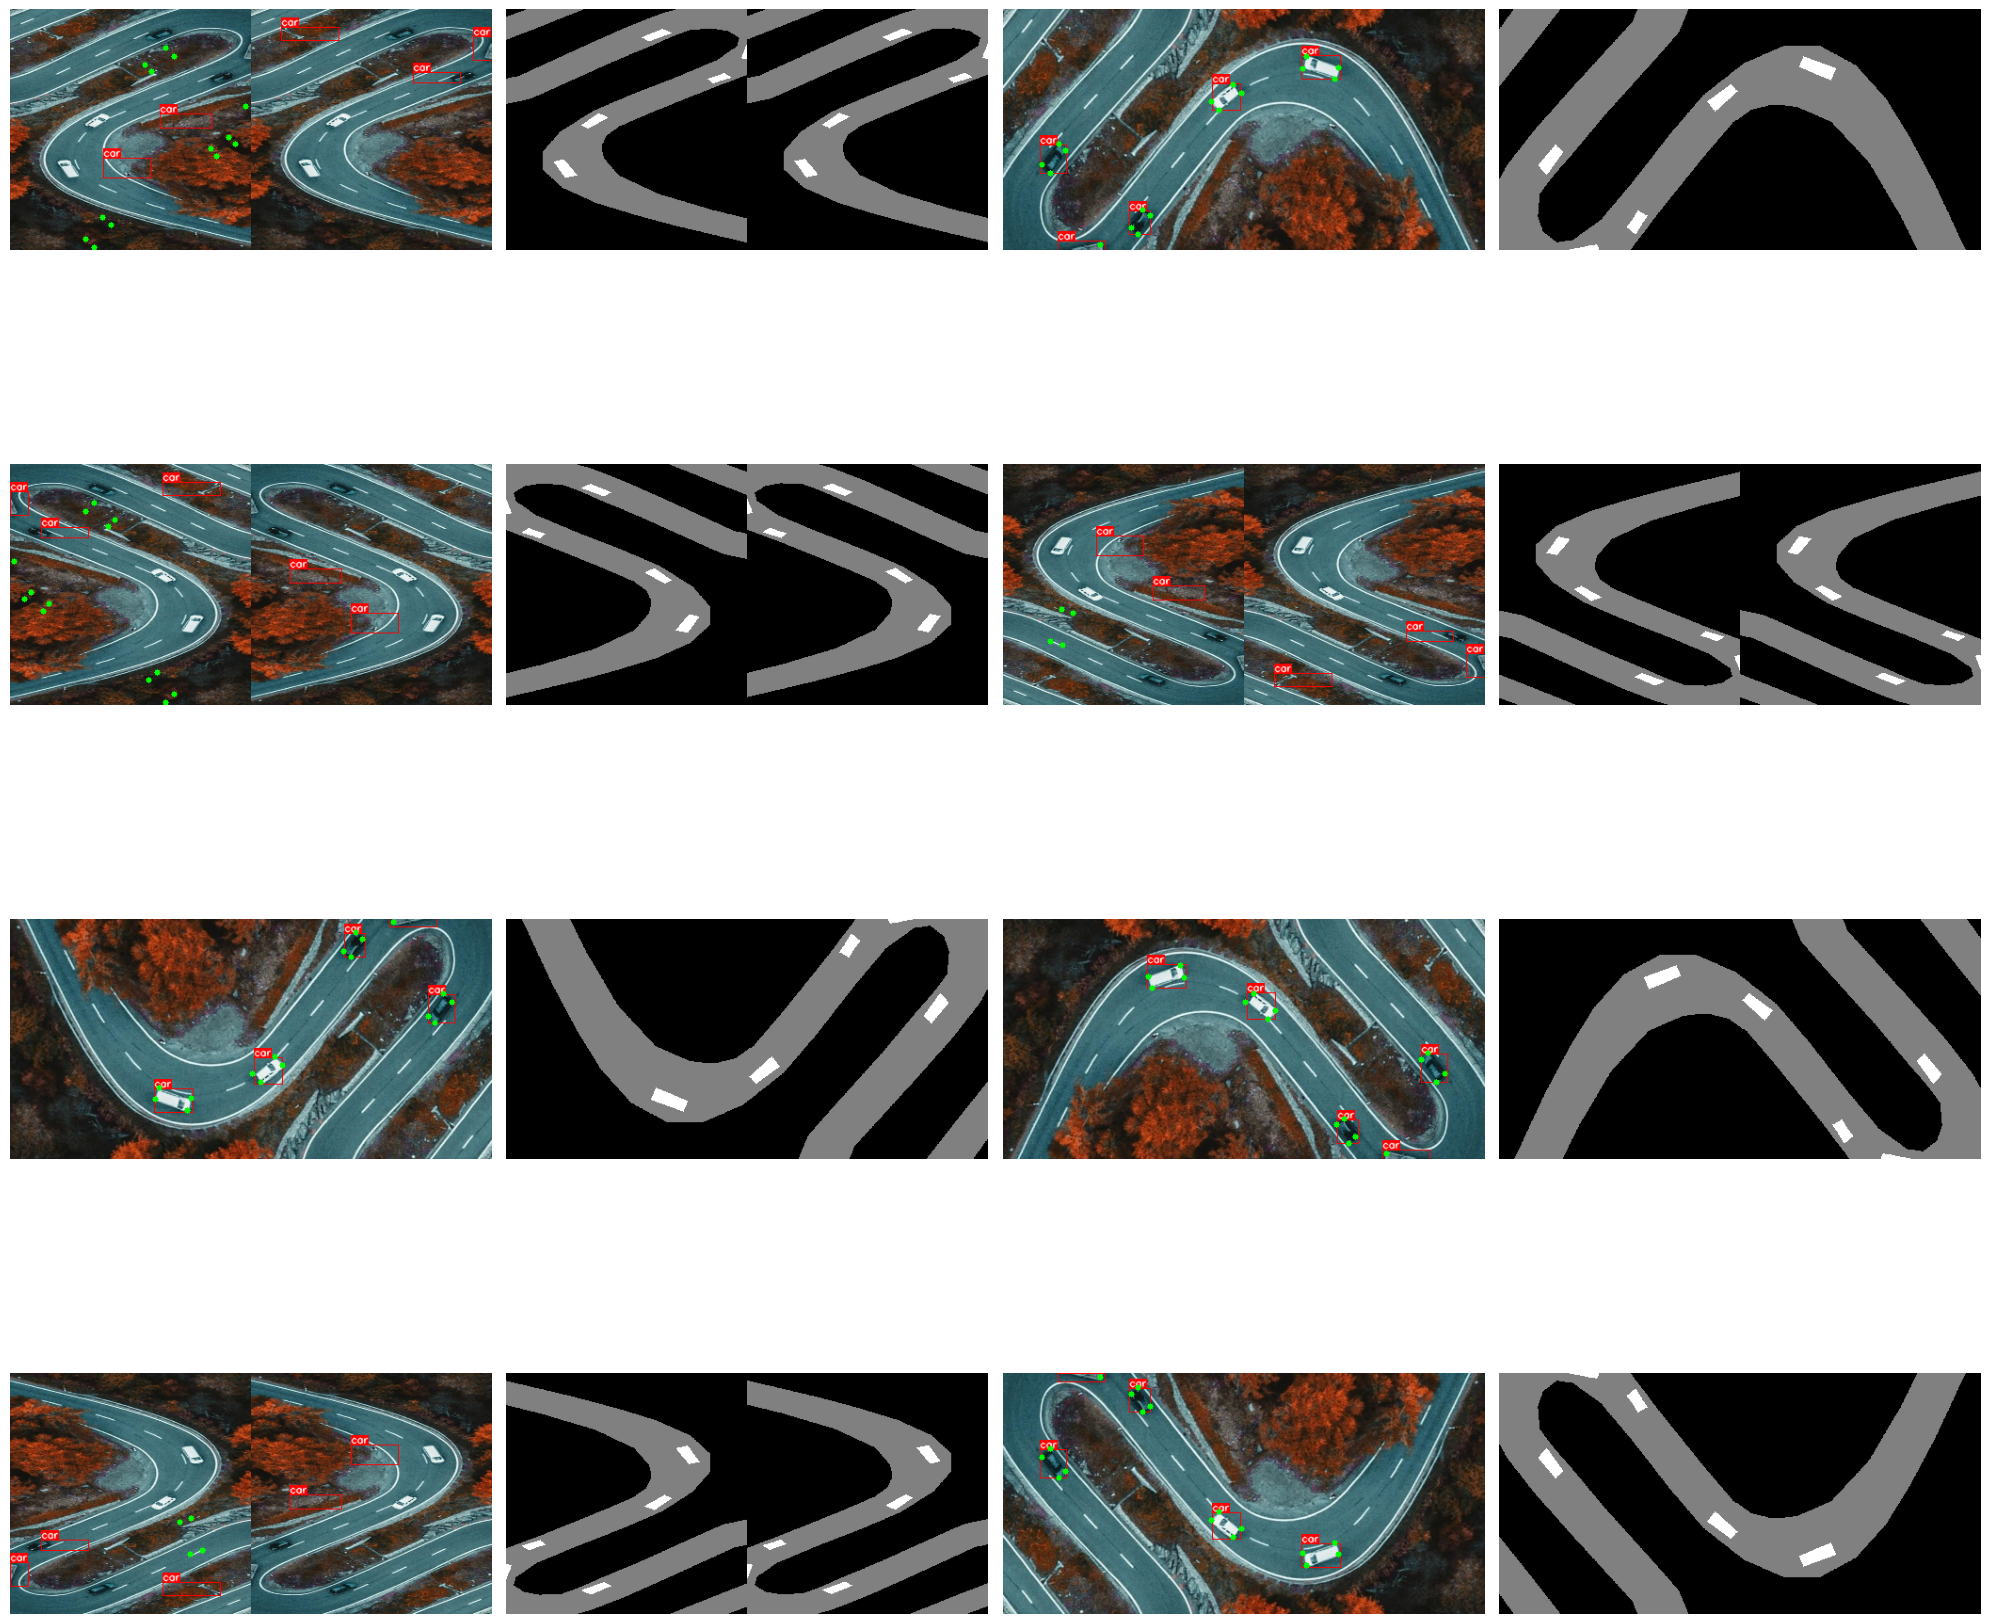

In [ ]:
visualize(images, bboxes_list, keypoints_list, category_ids_list, category_id_to_name, masks)

In [ ]:
image.shape

(512, 512, 3)

In [ ]:
d4(image[: 256, :], "r90").shape

(512, 256, 3)